In [1]:
import os
import pandas as pd
import re
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import en_core_web_lg

In [2]:
from gensim.models.phrases import Phrases, Phraser
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
nlp = en_core_web_lg.load()

In [4]:
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [5]:
file=open('text_polsat.txt','r')
content =file.read()
content_list = content.split(",")
file.close()

df=pd.DataFrame(content_list)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df[0])

t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()

Time to clean up everything: 2.32 mins


In [6]:
sent = [row.split() for row in df_clean['clean']]

In [7]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 11:11:03: collecting all words and their counts
INFO - 11:11:03: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 11:11:04: PROGRESS: at sentence #10000, processed 110202 words and 75097 word types
INFO - 11:11:04: PROGRESS: at sentence #20000, processed 223489 words and 133270 word types
INFO - 11:11:04: PROGRESS: at sentence #30000, processed 335856 words and 184178 word types
INFO - 11:11:04: collected 196436 word types from a corpus of 364667 words (unigram + bigrams) and 32481 sentences
INFO - 11:11:04: using 196436 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [9]:
bigram = Phraser(phrases)

INFO - 11:13:02: source_vocab length 196436
INFO - 11:13:04: Phraser built with 276 phrasegrams


In [10]:
sentences = bigram[sent]

In [11]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

15386

In [13]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['quot',
 'say',
 's',
 'poland',
 'people',
 'president',
 'year',
 'government',
 'polish',
 'state',
 'add',
 'video',
 'protest',
 'time',
 'prime_minister',
 'pis',
 'accord',
 'want',
 'minister',
 'work']

In [14]:
import multiprocessing

from gensim.models import Word2Vec

In [15]:
cores = multiprocessing.cpu_count()

In [16]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [17]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 11:16:45: collecting all words and their counts
INFO - 11:16:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 11:16:45: PROGRESS: at sentence #10000, processed 103941 words, keeping 8996 word types
INFO - 11:16:46: PROGRESS: at sentence #20000, processed 210882 words, keeping 12201 word types
INFO - 11:16:46: PROGRESS: at sentence #30000, processed 317021 words, keeping 14847 word types
INFO - 11:16:46: collected 15386 word types from a corpus of 344177 raw words and 32481 sentences
INFO - 11:16:46: Loading a fresh vocabulary
INFO - 11:16:46: effective_min_count=20 retains 2679 unique words (17% of original 15386, drops 12707)
INFO - 11:16:46: effective_min_count=20 leaves 298098 word corpus (86% of original 344177, drops 46079)
INFO - 11:16:46: deleting the raw counts dictionary of 15386 items
INFO - 11:16:46: sample=6e-05 downsamples 1454 most-common words
INFO - 11:16:46: downsampling leaves estimated 136491 word corpus (45.8% of prior 298098)
INFO

Time to build vocab: 0.03 mins


In [18]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 11:17:15: training model with 3 workers on 2679 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 11:17:16: EPOCH 1 - PROGRESS: at 55.41% examples, 72072 words/s, in_qsize 1, out_qsize 0
INFO - 11:17:17: worker thread finished; awaiting finish of 2 more threads
INFO - 11:17:17: worker thread finished; awaiting finish of 1 more threads
INFO - 11:17:17: worker thread finished; awaiting finish of 0 more threads
INFO - 11:17:17: EPOCH - 1 : training on 344177 raw words (136159 effective words) took 1.7s, 77963 effective words/s
INFO - 11:17:18: EPOCH 2 - PROGRESS: at 58.39% examples, 78242 words/s, in_qsize 0, out_qsize 0
INFO - 11:17:18: worker thread finished; awaiting finish of 2 more threads
INFO - 11:17:18: worker thread finished; awaiting finish of 1 more threads
INFO - 11:17:18: worker thread finished; awaiting finish of 0 more threads
INFO - 11:17:18: EPOCH - 2 : training on 344177 raw words (136615 effective words) took 1.6s, 83306 effect

INFO - 11:17:49: worker thread finished; awaiting finish of 1 more threads
INFO - 11:17:49: worker thread finished; awaiting finish of 0 more threads
INFO - 11:17:49: EPOCH - 19 : training on 344177 raw words (137129 effective words) took 1.6s, 83488 effective words/s
INFO - 11:17:50: EPOCH 20 - PROGRESS: at 61.29% examples, 82343 words/s, in_qsize 0, out_qsize 0
INFO - 11:17:50: worker thread finished; awaiting finish of 2 more threads
INFO - 11:17:50: worker thread finished; awaiting finish of 1 more threads
INFO - 11:17:50: worker thread finished; awaiting finish of 0 more threads
INFO - 11:17:50: EPOCH - 20 : training on 344177 raw words (136723 effective words) took 1.6s, 85086 effective words/s
INFO - 11:17:51: EPOCH 21 - PROGRESS: at 52.42% examples, 66333 words/s, in_qsize 0, out_qsize 0
INFO - 11:17:52: worker thread finished; awaiting finish of 2 more threads
INFO - 11:17:52: worker thread finished; awaiting finish of 1 more threads
INFO - 11:17:52: worker thread finished; aw

Time to train the model: 0.88 mins


In [19]:
w2v_model.init_sims(replace=True)

INFO - 11:18:20: precomputing L2-norms of word weight vectors


In [24]:
w2v_model.wv.most_similar(positive=["poland"])

[('lithuania', 0.711594820022583),
 ('enormous', 0.6771478652954102),
 ('sovereign', 0.6433546543121338),
 ('instrument', 0.6394235491752625),
 ('perspective', 0.6335359811782837),
 ('european_union', 0.616057813167572),
 ('reconstruction', 0.6143640279769897),
 ('element', 0.6084371209144592),
 ('history', 0.6012176275253296),
 ('cohesion', 0.6003053188323975)]

In [68]:
w2v_model.wv.most_similar(positive=["church"])

[('jesus', 0.7979860305786133),
 ('faithful', 0.7952812910079956),
 ('christ', 0.7929646968841553),
 ('decree', 0.7880860567092896),
 ('mary', 0.7859938740730286),
 ('catholic_church', 0.7828714847564697),
 ('primate', 0.782324492931366),
 ('temple', 0.7798126935958862),
 ('coffin', 0.7756281495094299),
 ('congregation', 0.7744137048721313)]

In [69]:
w2v_model.wv.most_similar(negative=["church"])

[('adam_niedzielski', 0.28538617491722107),
 ('niedzielski', 0.2614384591579437),
 ('predict', 0.25986117124557495),
 ('round', 0.22654223442077637),
 ('democrat_candidate', 0.21754249930381775),
 ('turnout', 0.21166172623634338),
 ('cast', 0.20899584889411926),
 ('table', 0.20553353428840637),
 ('minister_health', 0.20468395948410034),
 ('percent', 0.19975414872169495)]

In [73]:
w2v_model.wv.similarity("kukiz", 'church')

0.08300589

In [72]:
w2v_model.wv.similarity("bosak", 'church')

-0.02617699

In [37]:
w2v_model.wv.doesnt_match(['morawiecki', 'duda', 'kaczynski'])

C:\Users\Kacper\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'duda'

In [38]:
w2v_model.wv.doesnt_match(['pis', 'confederation', 'po'])

'po'

In [79]:
w2v_model.wv.most_similar(positive=['pope'], topn=20)

[('benedict_xvi', 0.9175349473953247),
 ('retired', 0.9004315137863159),
 ('retire', 0.8762041330337524),
 ('ii', 0.8537873029708862),
 ('john_paul', 0.8337132930755615),
 ('ratzinger', 0.8255810737609863),
 ('francis', 0.8235081434249878),
 ('cardinal', 0.8224861025810242),
 ('mccarrick', 0.8079471588134766),
 ('pope_francis', 0.7896554470062256),
 ('georg', 0.7852446436882019),
 ('rome', 0.7835760116577148),
 ('saint', 0.7802672982215881),
 ('lord', 0.7719900608062744),
 ('vatican', 0.7699165344238281),
 ('faith', 0.7671256065368652),
 ('dziwisz', 0.7655847072601318),
 ('italian', 0.7629499435424805),
 ('father', 0.7626522779464722),
 ('figure', 0.7557860612869263)]

In [45]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [53]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=18).fit_transform(arrays)#zmiana z 50  na 18
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

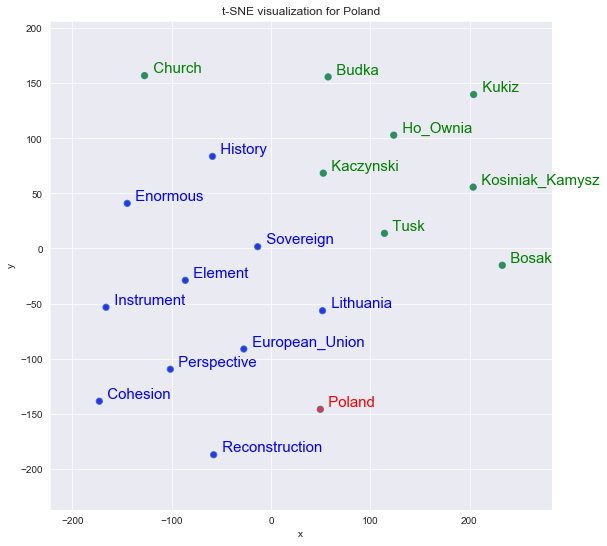

In [55]:
tsnescatterplot(w2v_model, 'poland', ['tusk', 'kaczynski', 'budka', 'ho_ownia', 'kukiz', 'kosiniak_kamysz','bosak','church'])

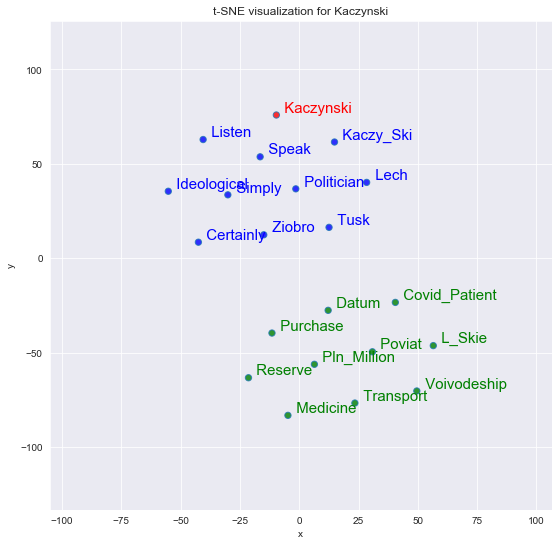

In [58]:
tsnescatterplot(w2v_model, 'kaczynski', [i[0] for i in w2v_model.wv.most_similar(negative=["kaczynski"])])

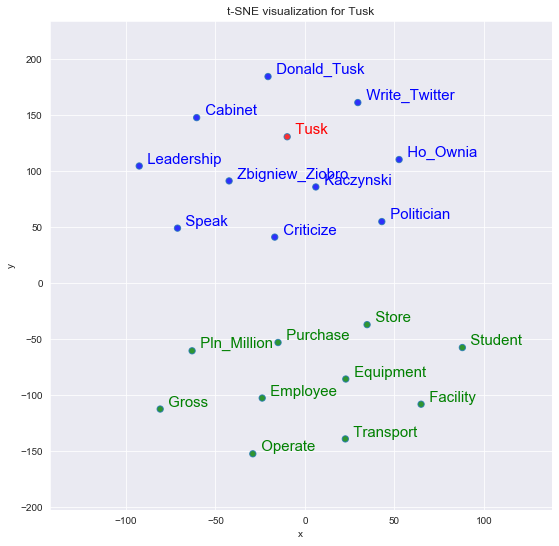

In [60]:
tsnescatterplot(w2v_model, 'tusk', [i[0] for i in w2v_model.wv.most_similar(negative=["tusk"])])

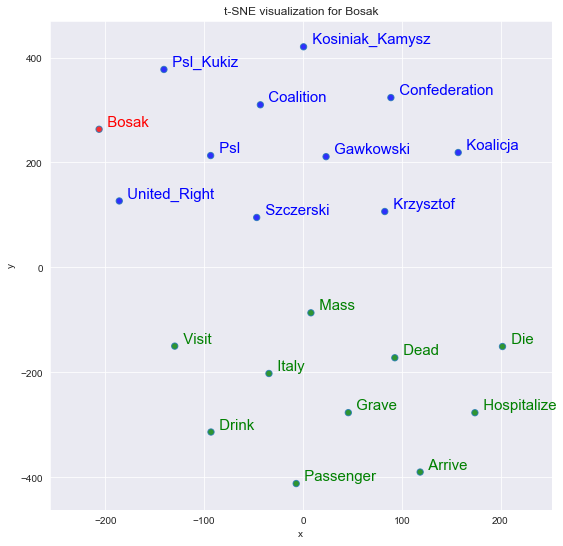

In [62]:
tsnescatterplot(w2v_model, 'bosak', [i[0] for i in w2v_model.wv.most_similar(negative=["bosak"])])

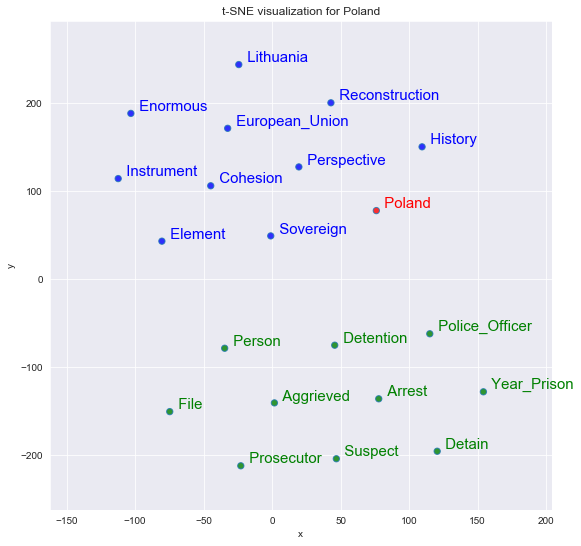

In [65]:
tsnescatterplot(w2v_model, 'poland', [i[0] for i in w2v_model.wv.most_similar(negative=["poland"])])

In [67]:
tsnescatterplot(w2v_model, 'European_Union', [i[0] for i in w2v_model.wv.most_similar(negative=["European_Union"])])

KeyError: "word 'European_Union' not in vocabulary"